In [8]:
# Harshadeep Kambhampati (hk24873), Ian Wang, Arkady Marchenko, Andy Jiang

# ML Course Project

In [9]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [10]:
# Import data
df = pd.read_csv("cattle_data_train.csv")
df.info()
df.describe()


# print((df['Rumination_Time_hrs'] < 0).sum())


# OBSERVATIONS from describe():
# 34 actual features to predict with (excluding Cattle_ID and Milk_Yield_L as our class label)
# No NaNs except for housing_score and feed_quantity in both kg and lbs: not too many, 10000 ish out of 200000
# The min of Milk Yield for some reason is negative, which doesn't make sense?... what even is a negative yield
# What is a negative Rumination Time (the bottom 50% is all negative)? 
# Parity is the number of times a cow has given birth

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210000 entries, 0 to 209999
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Cattle_ID                210000 non-null  object 
 1   Breed                    210000 non-null  object 
 2   Climate_Zone             210000 non-null  object 
 3   Management_System        210000 non-null  object 
 4   Age_Months               210000 non-null  int64  
 5   Weight_kg                210000 non-null  float64
 6   Parity                   210000 non-null  int64  
 7   Lactation_Stage          210000 non-null  object 
 8   Days_in_Milk             210000 non-null  int64  
 9   Feed_Type                210000 non-null  object 
 10  Feed_Quantity_kg         199519 non-null  float64
 11  Feeding_Frequency        210000 non-null  int64  
 12  Water_Intake_L           210000 non-null  float64
 13  Walking_Distance_km      210000 non-null  float64
 14  Graz

,Age_Months,Weight_kg,Parity,Days_in_Milk,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Rumination_Time_hrs,...,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Feed_Quantity_lb,Mastitis,Milk_Yield_L
count,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,...,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000
mean,83.483905,499.930430,3.500395,182.112967,12.014793,2.999119,80.036850,4.034754,6.056710,0.256557,...,0.600381,0.598814,0.599824,0.600824,8.747584,3.394726,12.302438,26.492720,0.099976,15.589156
std,34.648982,144.659172,1.707383,105.051486,3.969247,1.413147,14.987677,1.928529,2.867575,6.115351,...,0.489821,0.490140,0.489935,0.489730,5.901473,0.632831,4.298998,8.741282,0.299969,5.352079
min,24.000000,250.000000,1.000000,1.000000,2.370284,1.000000,14.207737,0.500000,1.000000,-8.808053,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,6.615000,0.000000,-5.700324
25%,54.000000,374.200000,2.000000,91.000000,9.283265,2.000000,69.919162,2.650000,4.000000,-4.383302,...,0.000000,0.000000,0.000000,0.000000,4.270000,3.000000,12.000000,20.506500,0.000000,11.822207
50%,83.000000,500.200000,3.000000,182.000000,12.002254,3.000000,80.016973,4.000000,6.000000,-0.818631,...,1.000000,1.000000,1.000000,1.000000,7.710000,3.500000,12.000000,26.460000,0.000000,15.145871
75%,114.000000,625.700000,5.000000,273.000000,14.708920,4.000000,90.119812,5.350000,8.000000,4.051704,...,1.000000,1.000000,1.000000,1.000000,12.410000,4.000000,12.000000,32.413500,0.000000,18.884708
max,143.000000,750.000000,6.000000,364.000000,25.454207,5.000000,149.960210,12.000000,14.000000,31.263406,...,1.000000,1.000000,1.000000,1.000000,38.670000,5.000000,24.000000,55.125000,1.000000,44.555285


# Data Cleaning

In [11]:
# DATA CLEANING (outside of pipeline)

# Dropping Cattle_ID as it is just an identifier, not useful for prediction
df = df.drop(columns=['Cattle_ID'])

# Converting our Date into a day of the year and year features, usable numeric data
df['Date'] = pd.to_datetime(df['Date'])
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Year'] = df['Date'].dt.year
df = df.drop(columns=['Date'])


# Handling NaN values for Feed_Quantity: We will keep only KG and convert LBS to KG for NaNs, then drop LBS
FEED_QTY_LBS_TO_KG = 0.453592
df['Feed_Quantity_kg'] = df['Feed_Quantity_kg'].fillna(df['Feed_Quantity_lb'] * FEED_QTY_LBS_TO_KG)
df = df.drop(columns=['Feed_Quantity_lb'])
print("Number of missing values after lb to kg conversion (we may need to handle with imputation later):", df.isna().sum().sum())


# NOTE: Something weird we noticed here is that we have some different string representations of the same breed due to trailing spaces and spelling ('Holstein' and 'Holstein ')
# We should probably clean that up right now
df['Breed'] = df['Breed'].str.strip()
df['Breed'] = df['Breed'].replace('Holstien', 'Holstein')
for b in df['Breed'].unique():
    print(repr(b))


# We should drop our "negative" milk yields as those entries don't really make sense
print("Number of negative milk yield entries being dropped:", (df['Milk_Yield_L'] < 0).sum())
df = df[df['Milk_Yield_L'] >= 0]


# Something we noticed during exploration, we have a lot of entries with Previous_Week_Avg_Yield = 0 (about 6600)
# BUT they seem to have perfectly normal Milk_Yield_L and Days_in_Milk values, which doesn't make sense at all. How can a cow have 0
# average yield last week but have a positive yield this week and have been in milk for many days?
# We assume these 0s to be implicit NaNs and these cows must have missing data for their last week yield, we will impute them later
# There may also be some association between all of these 0 previous week yields, so we will create a new feature as a flag for this
print("Number of entries with Previous_Week_Avg_Yield = 0:", (df['Previous_Week_Avg_Yield'] == 0).sum())

zero_prev = df[df['Previous_Week_Avg_Yield'] == 0]
print(zero_prev['Milk_Yield_L'].describe())
print(zero_prev['Days_in_Milk'].describe())

df['Previous_Week_Avg_Yield'] = df['Previous_Week_Avg_Yield'].replace(0, np.nan)


# NEW BINARY FLAGS
df['Prev_Week_Missing'] = (df['Previous_Week_Avg_Yield'].isna()).astype(int)
df['Is_Late_Lactation'] = (df['Days_in_Milk'] > 250).astype(int) # past 250 seems to be when yield drops off most


Number of missing values after lb to kg conversion (we may need to handle with imputation later): 16760
'Holstein'
'Jersey'
'Guernsey'
'Brown Swiss'
Number of negative milk yield entries being dropped: 74
Number of entries with Previous_Week_Avg_Yield = 0: 6662
count    6662.000000
mean       14.821080
std         5.316991
min         0.392622
25%        11.046382
50%        14.440192
75%        18.111401
max        41.531320
Name: Milk_Yield_L, dtype: float64
count    6662.000000
mean      202.692735
std       113.767234
min         1.000000
25%       102.000000
50%       222.000000
75%       308.000000
max       364.000000
Name: Days_in_Milk, dtype: float64


# Data Exploration

## Numerical Analysis

In [12]:
# DATA EXPLORATION
# NOTE: We should really finish encoding all of our categorical features properly before analyzing correlation/variance
# TODO: We should probably use some data visualizations/distributions here as well for exploration
# TODO: Identify outliers

# target_corr = df.corr(numeric_only=True)['Milk_Yield_L'].sort_values(ascending=False)
# print(target_corr)


# Let's take a look at the correlation between each of the features and the label
df_encoded = df.copy()

for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

df_encoded.corr()['Milk_Yield_L'].sort_values(ascending=False)

# Observations:
# - Interestingly, Weight_kg, Feed_Quantity_kg, Age_Months, Parity all have the highest correlation over 0.2
# - We have a lot of very low correlation features that may be best to drop
# - Since Feed_Quantity_kg actually has a high correlation, we should have good imputation for it to avoid losing that info for missing entries

Milk_Yield_L               1.000000
Weight_kg                  0.300240
Feed_Quantity_kg           0.222856
Water_Intake_L             0.125022
Rumination_Time_hrs        0.089412
Previous_Week_Avg_Yield    0.086917
IBR_Vaccine                0.072186
Anthrax_Vaccine            0.069584
Rabies_Vaccine             0.068090
Milking_Interval_hrs       0.014635
Grazing_Duration_hrs       0.004278
Housing_Score              0.004054
Humidity_percent           0.002337
Brucellosis_Vaccine        0.002065
Year                       0.001998
BVD_Vaccine                0.000692
Breed                      0.000636
Feeding_Frequency          0.000465
Farm_ID                    0.000105
HS_Vaccine                -0.000038
Climate_Zone              -0.000451
Feed_Type                 -0.000488
BQ_Vaccine                -0.000576
Walking_Distance_km       -0.001608
Resting_Hours             -0.001703
Body_Condition_Score      -0.001951
Management_System         -0.002054
FMD_Vaccine               -0

In [13]:
# Let's also check for variance across all features and see if we have any low variance features to consider filtering
feature_variances = df_encoded.var().sort_values()
print(feature_variances)

# Seems like all of the features demonstrate some variance, looks significant enough not to drop any based on variance alone

Prev_Week_Missing              0.030728
Housing_Score                  0.041013
Mastitis                       0.089968
Is_Late_Lactation              0.214544
Rabies_Vaccine                 0.239815
BQ_Vaccine                     0.239857
Anthrax_Vaccine                0.239919
Brucellosis_Vaccine            0.239986
BVD_Vaccine                    0.240043
HS_Vaccine                     0.240069
FMD_Vaccine                    0.240142
IBR_Vaccine                    0.240230
Body_Condition_Score           0.400456
Year                           0.665733
Lactation_Stage                0.690784
Breed                          0.885638
Feeding_Frequency              1.997108
Management_System              1.999275
Parity                         2.914924
Climate_Zone                   2.917710
Walking_Distance_km            3.719208
Feed_Type                      5.246443
Resting_Hours                  8.211616
Grazing_Duration_hrs           8.223133
Feed_Quantity_kg              15.753011


In [14]:
# Checking for any outliers in the data and how severe of a problem this may be for the model later on down the line

for col in df.select_dtypes(include=[np.number]).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"{col}: {outliers} outliers ({outliers/len(df):.2%})")

    # Most features look good, but Milking_Interval_hrs is absurd with 30% outliers and Mastitis with 10% outliers
    # Mastitis is a binary feature, so those outliers are probably just the less common class
    # Milking_Interval_hrs looks like it just has a multi-modal distribution so these outliers look fine as well

Age_Months: 0 outliers (0.00%)
Weight_kg: 0 outliers (0.00%)
Parity: 0 outliers (0.00%)
Days_in_Milk: 0 outliers (0.00%)
Feed_Quantity_kg: 674 outliers (0.32%)
Feeding_Frequency: 0 outliers (0.00%)
Water_Intake_L: 1483 outliers (0.71%)
Walking_Distance_km: 747 outliers (0.36%)
Grazing_Duration_hrs: 0 outliers (0.00%)
Rumination_Time_hrs: 2406 outliers (1.15%)
Resting_Hours: 0 outliers (0.00%)
Ambient_Temperature_C: 196 outliers (0.09%)
Humidity_percent: 0 outliers (0.00%)
Housing_Score: 0 outliers (0.00%)
FMD_Vaccine: 0 outliers (0.00%)
Brucellosis_Vaccine: 0 outliers (0.00%)
HS_Vaccine: 0 outliers (0.00%)
BQ_Vaccine: 0 outliers (0.00%)
Anthrax_Vaccine: 0 outliers (0.00%)
IBR_Vaccine: 0 outliers (0.00%)
BVD_Vaccine: 0 outliers (0.00%)
Rabies_Vaccine: 0 outliers (0.00%)
Previous_Week_Avg_Yield: 2426 outliers (1.16%)
Body_Condition_Score: 0 outliers (0.00%)
Milking_Interval_hrs: 62813 outliers (29.92%)
Mastitis: 20984 outliers (10.00%)
Milk_Yield_L: 2604 outliers (1.24%)
Day_of_Year: 0 o

## Data Visualization

Numeric columns: 31


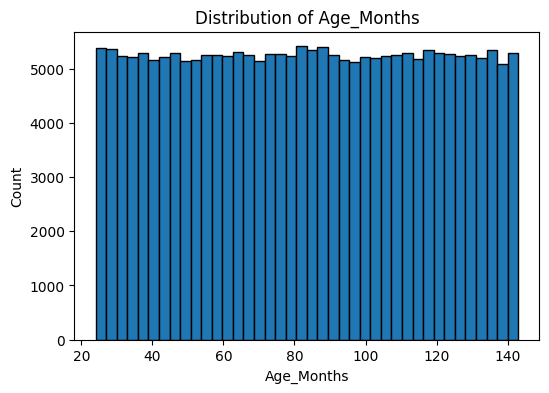

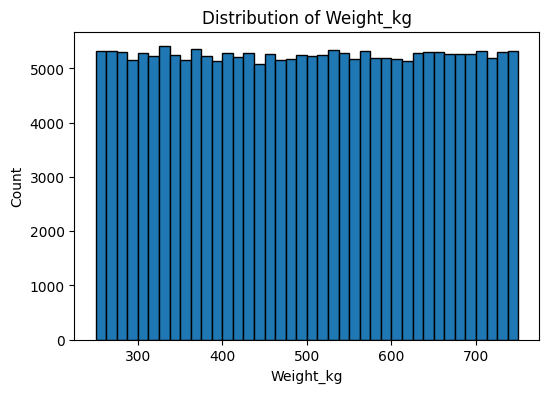

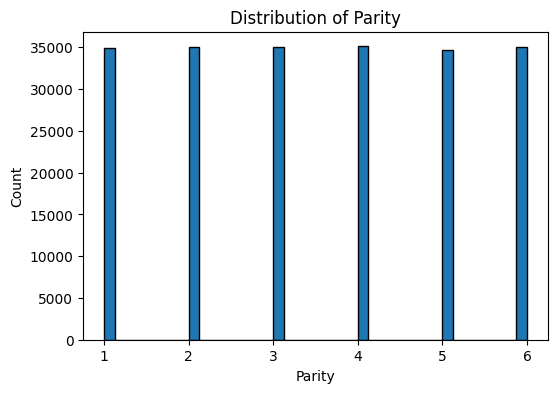

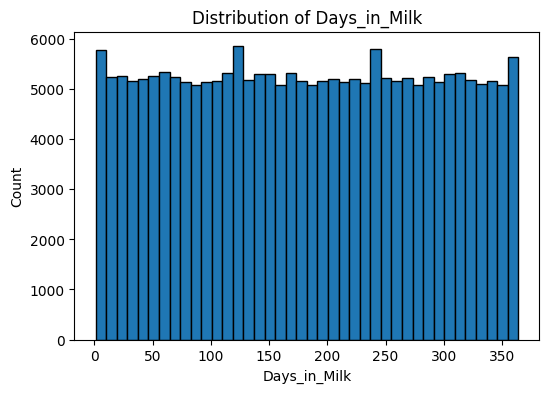

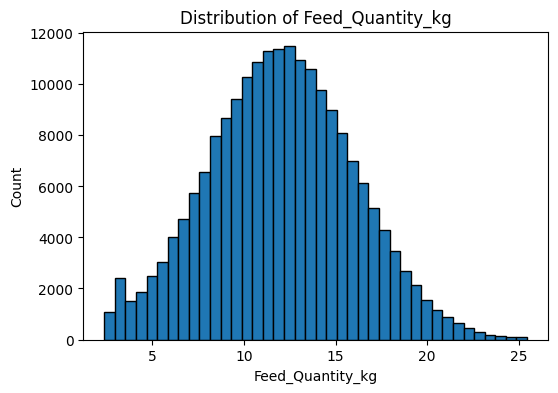

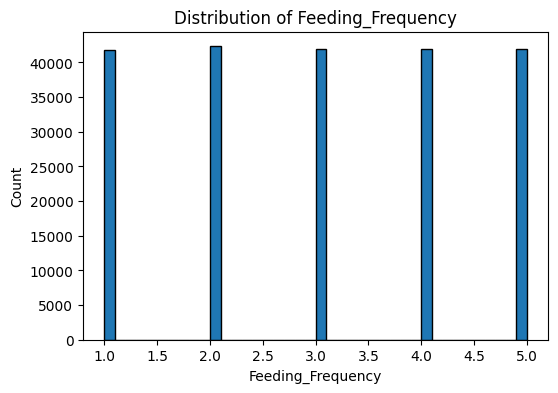

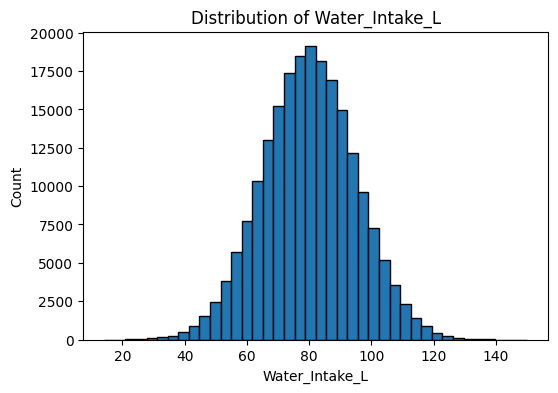

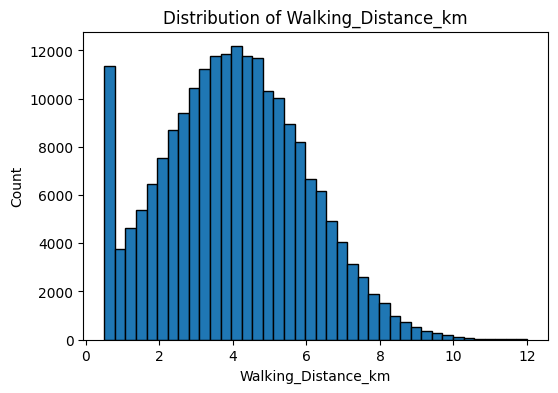

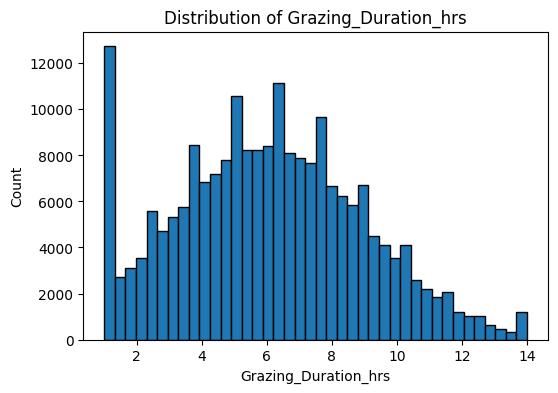

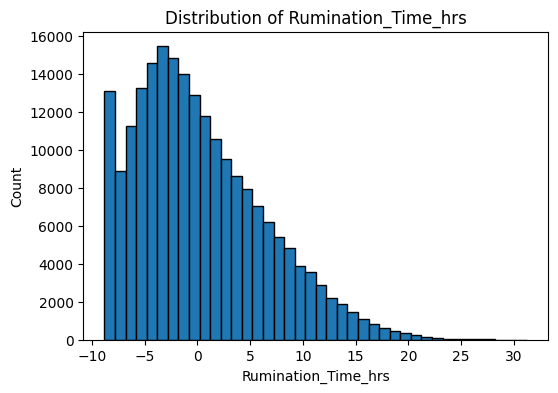

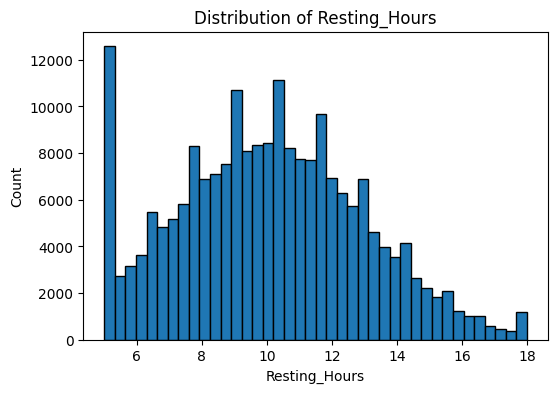

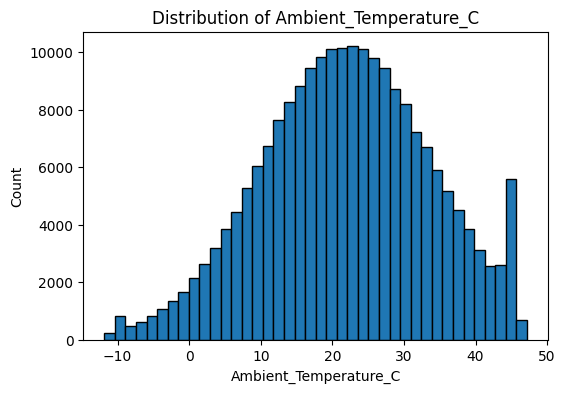

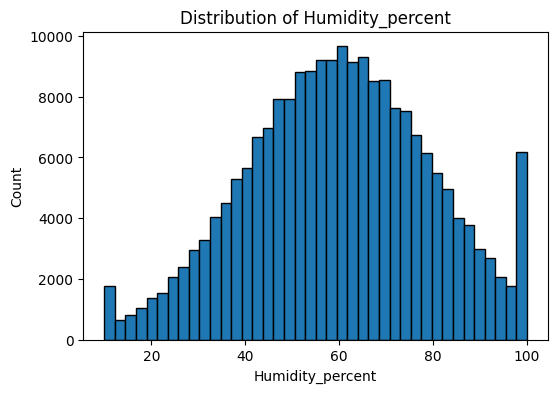

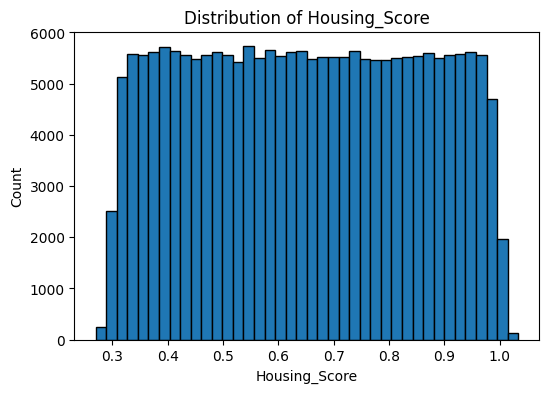

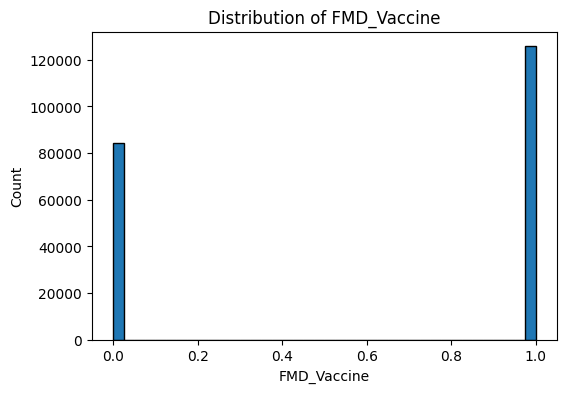

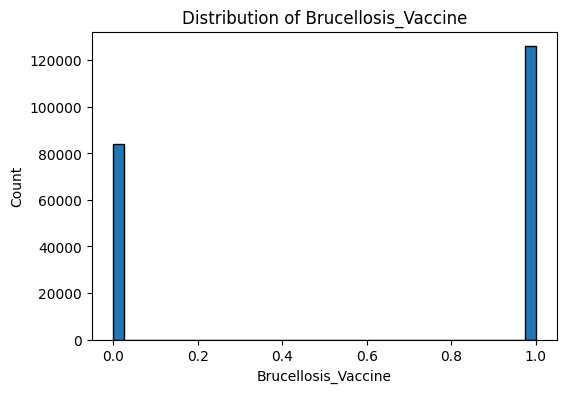

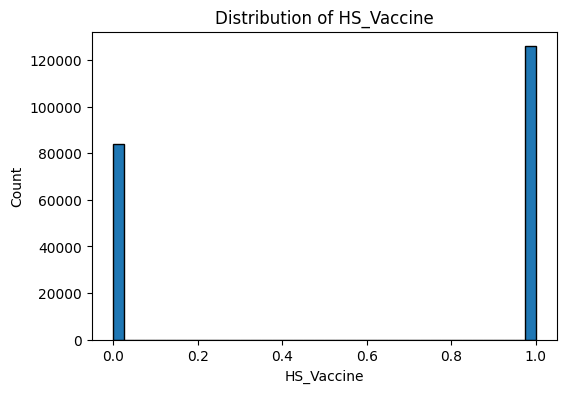

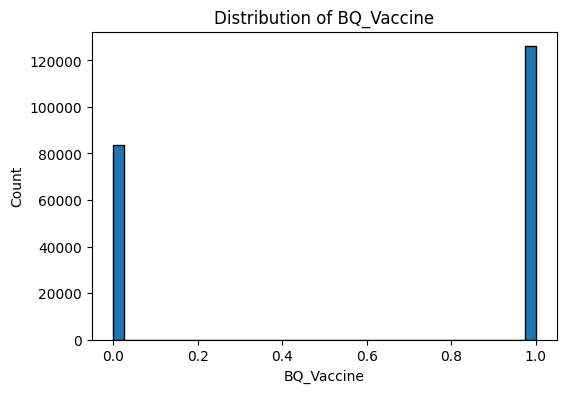

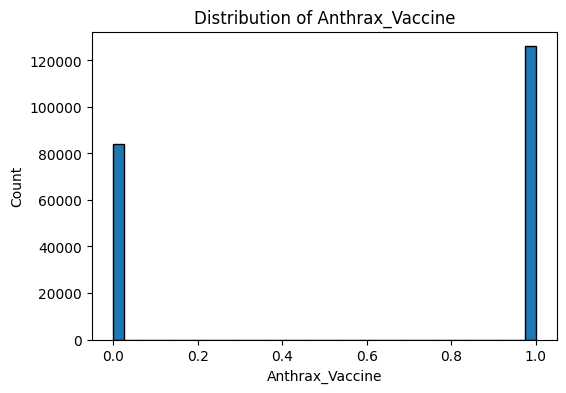

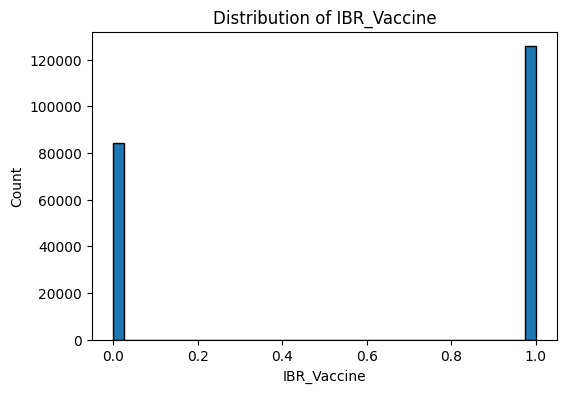

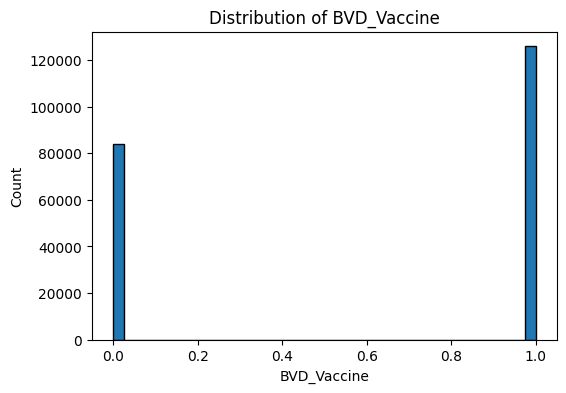

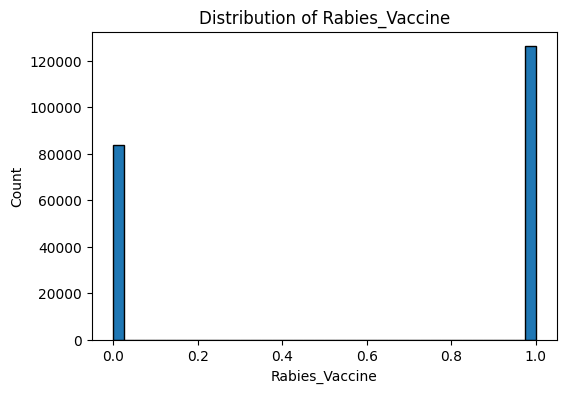

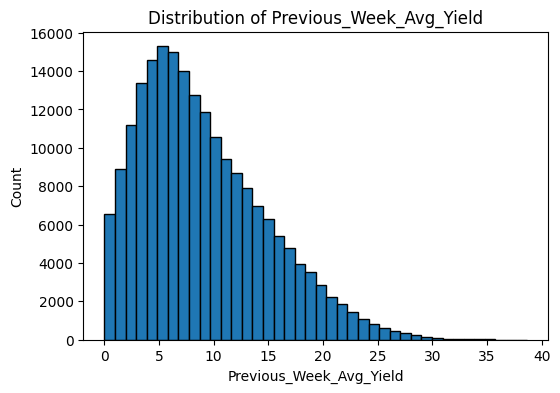

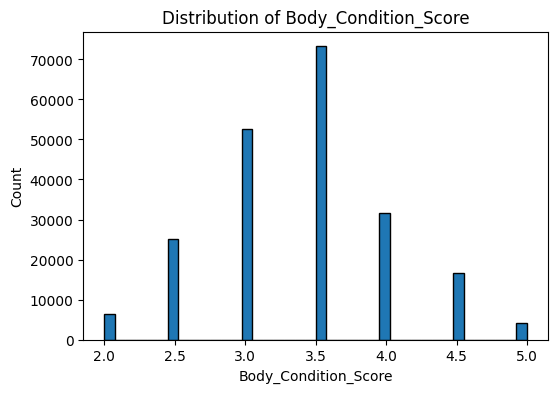

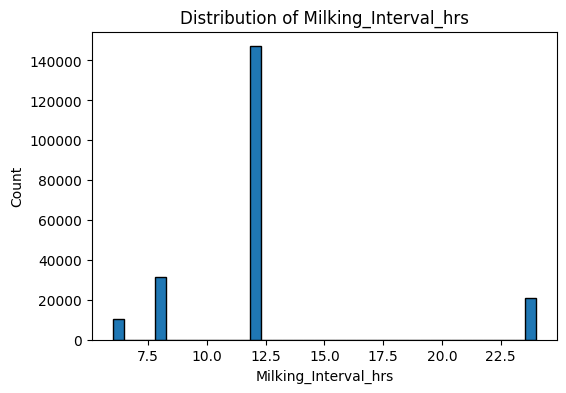

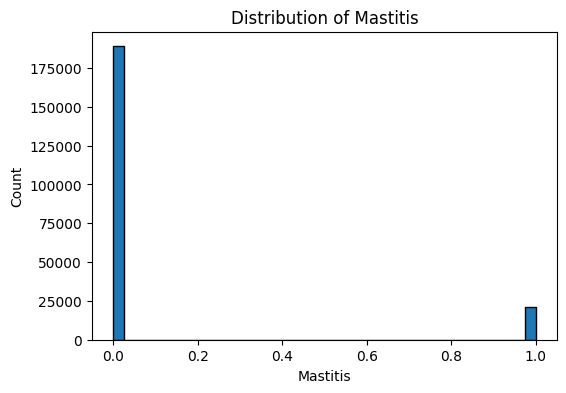

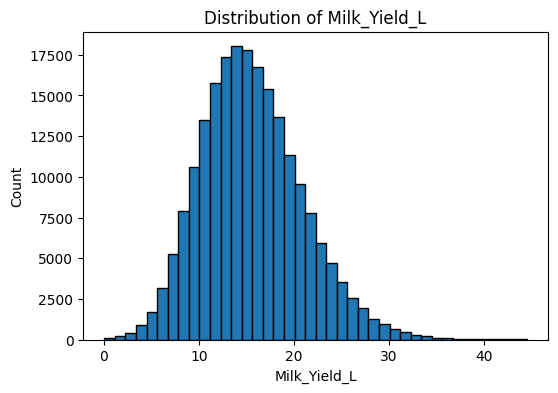

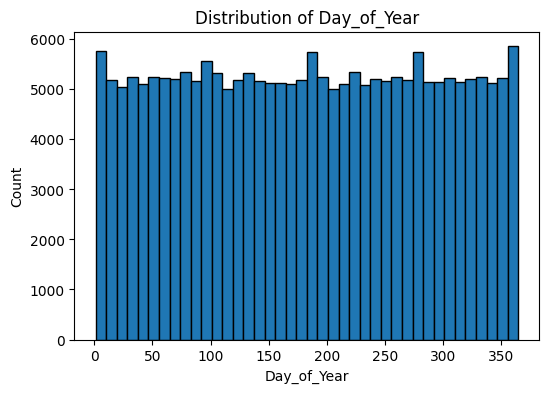

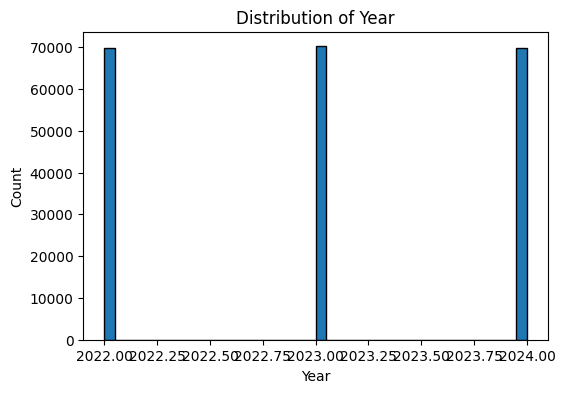

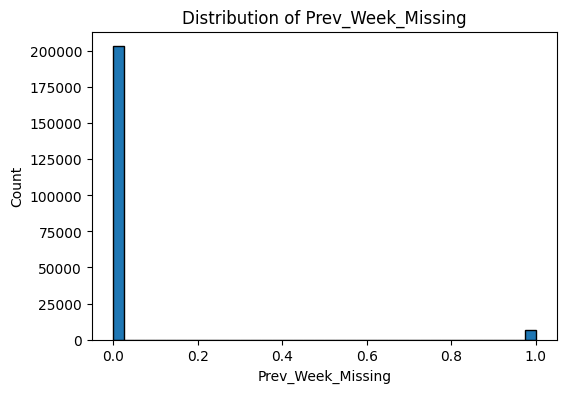

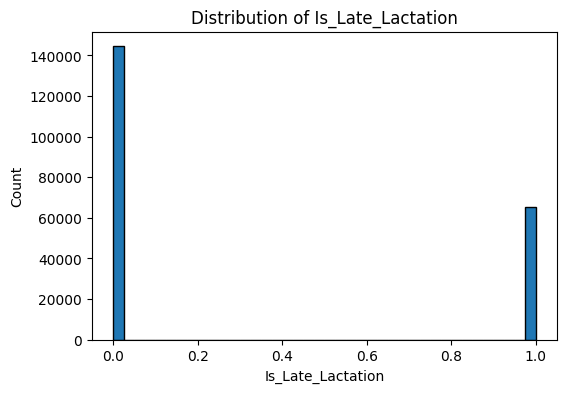

In [15]:
# DATA EXPLORATION: Distributions for Numeric Features

# First lets go ahead and take a look at the distributions of all our numeric features, see if there's anything interesting (skewness, outliers, negatives, etc.)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Looks like we have 7 categorical features that are non-numeric: Breed, Climate_Zone, Management_System, Lactation_Stage, Feed_Type, Date, Farm_ID
print("Numeric columns:", numeric_cols.__len__())

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    df[col].plot(kind='hist', bins=40, edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


# Milk Yield seems to be normally or slightly right-skewed distributed, not too many outliers

0
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Milk_Yield_L, dtype: float64
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Days_in_Milk, dtype: float64


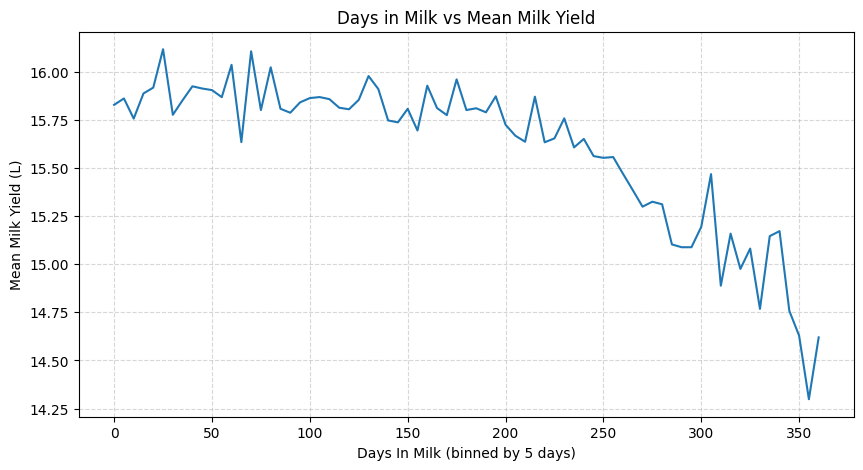

In [16]:
# RANDOM DATA EXPLORATION

# Testing the previous week zero yield entries here
zero_prev = df[df['Previous_Week_Avg_Yield'] == 0]
print(len(zero_prev))
print(zero_prev['Milk_Yield_L'].describe())
print(zero_prev['Days_in_Milk'].describe())



# We are taking a look at Days in Milk to see where the biggest falloff in milk yield happens
# Bin Days_in_Milk into groups (every 5 days)
df['DIM_bin'] = (df['Days_in_Milk'] // 5) * 5

curve = df.groupby('DIM_bin')['Milk_Yield_L'].mean()
plt.figure(figsize=(10,5))
plt.plot(curve.index, curve.values)
plt.xlabel("Days In Milk (binned by 5 days)")
plt.ylabel("Mean Milk Yield (L)")
plt.title("Days in Milk vs Mean Milk Yield")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
# Looks like it happens around 250 days, starting to drop off at 200 days

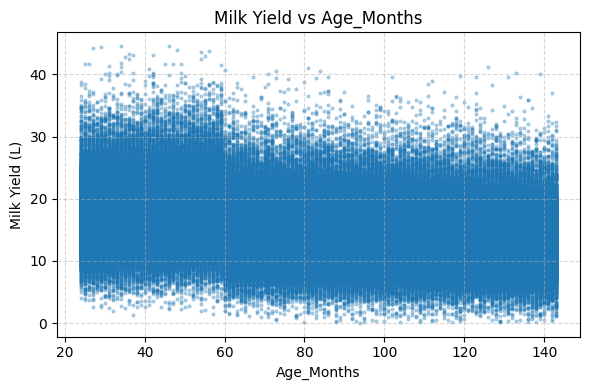

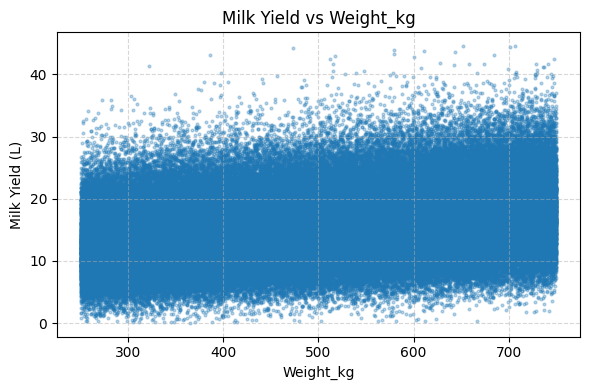

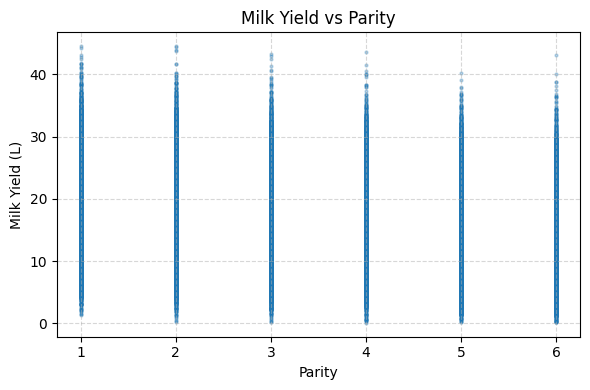

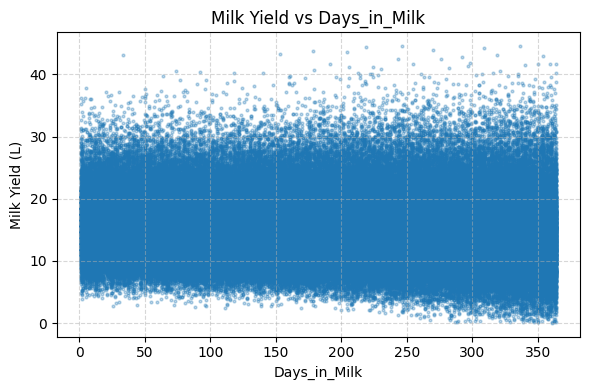

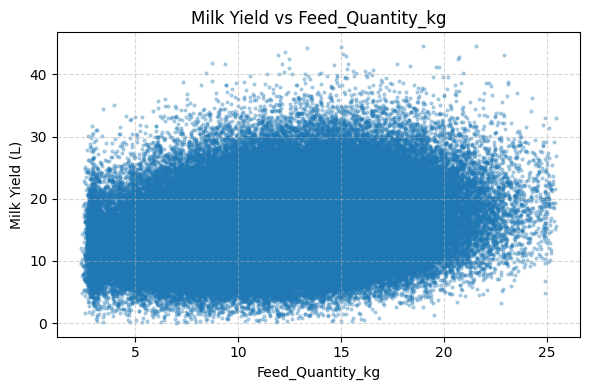

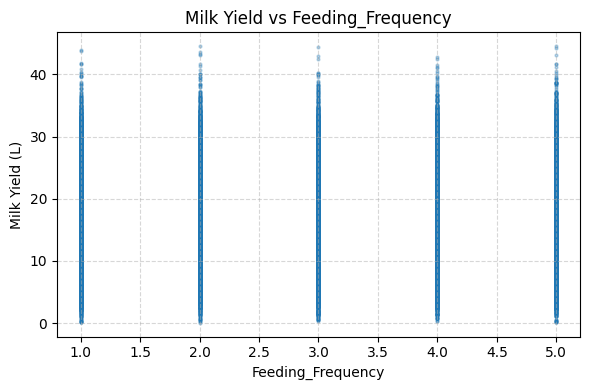

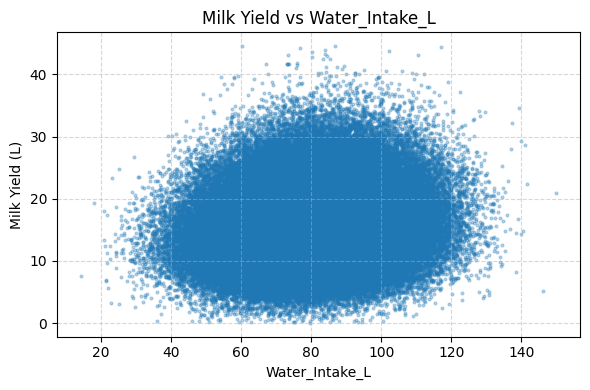

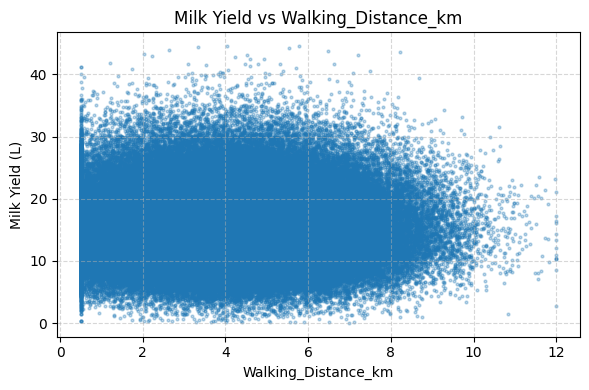

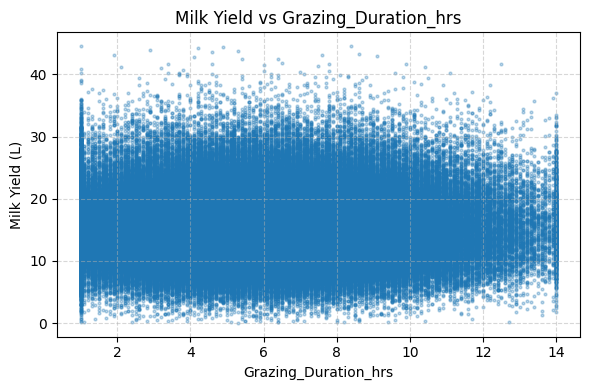

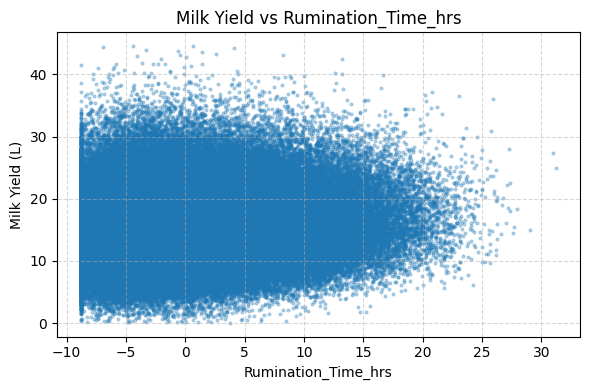

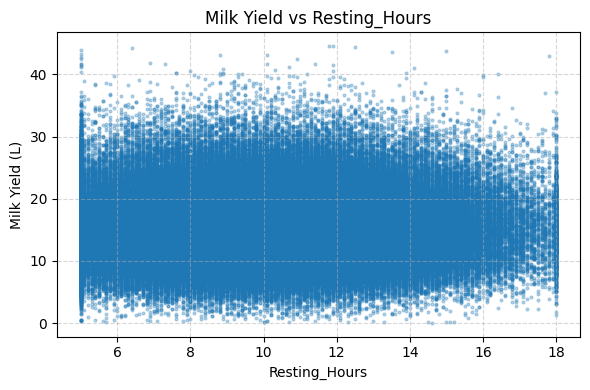

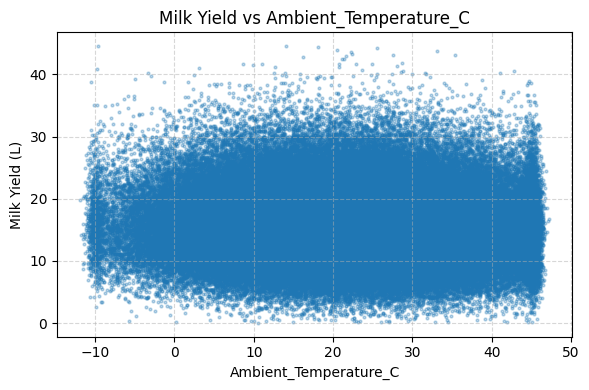

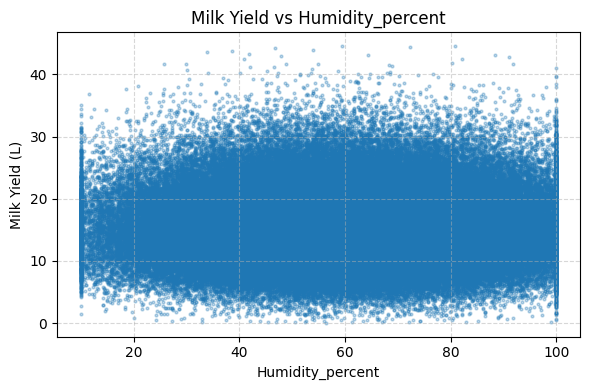

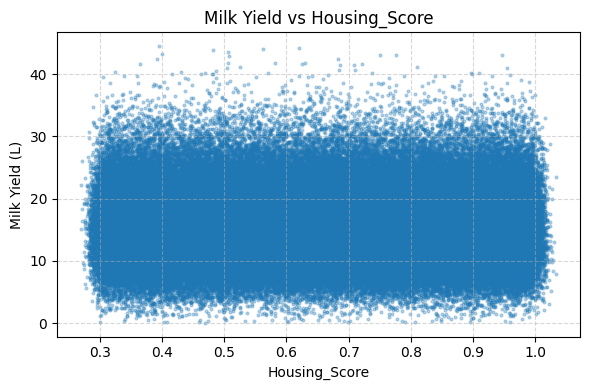

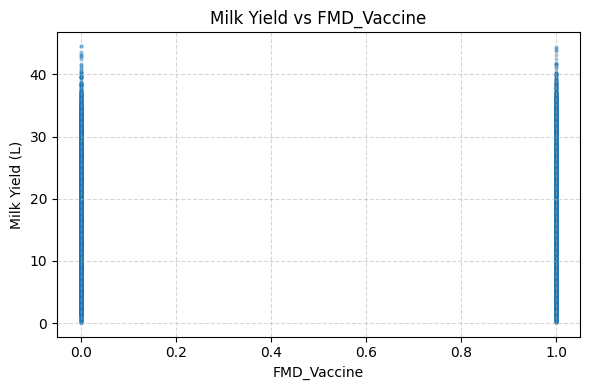

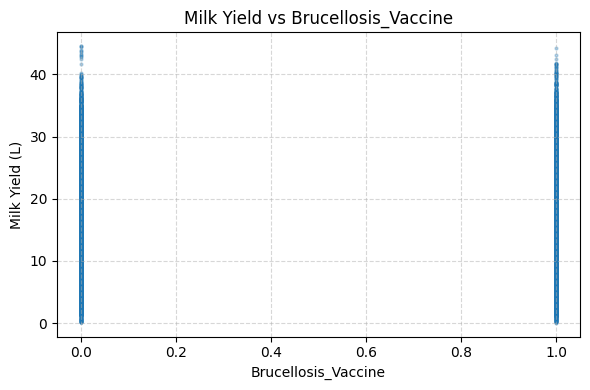

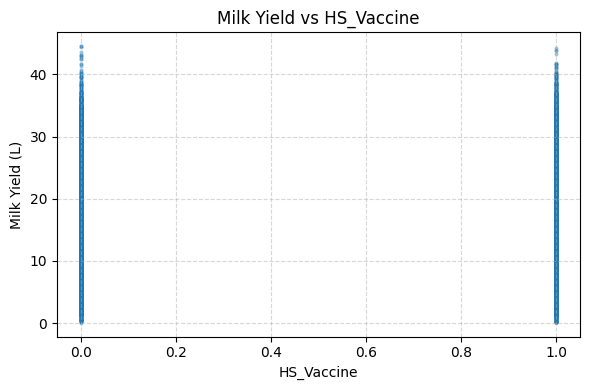

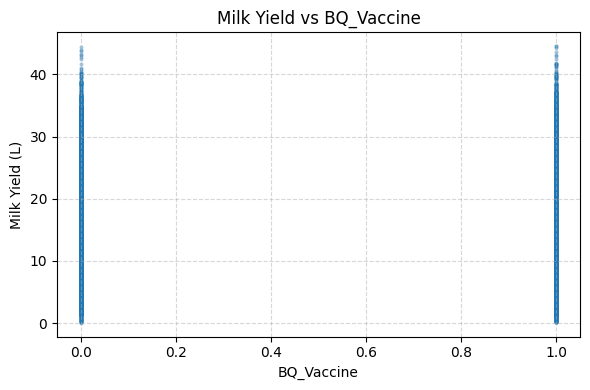

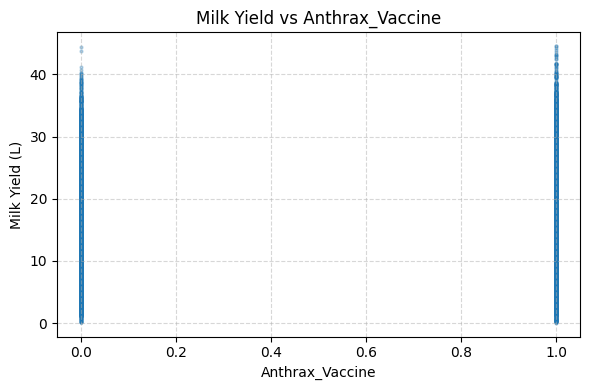

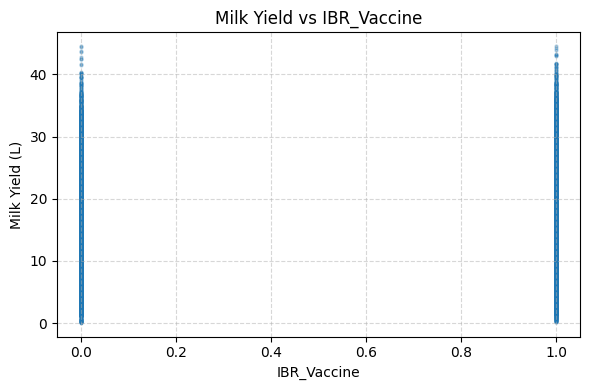

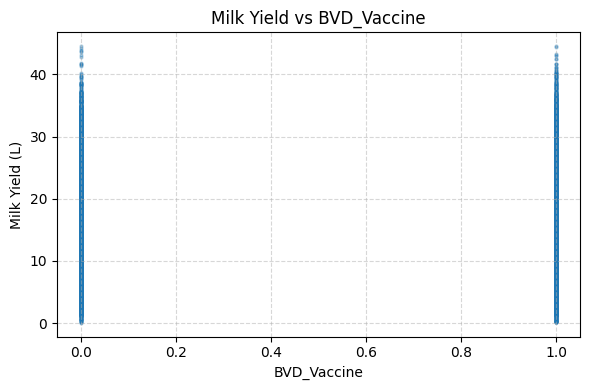

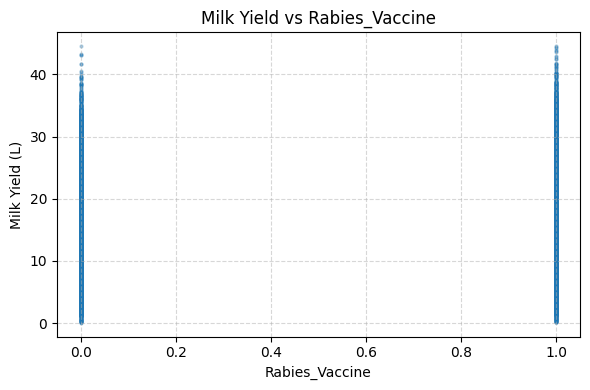

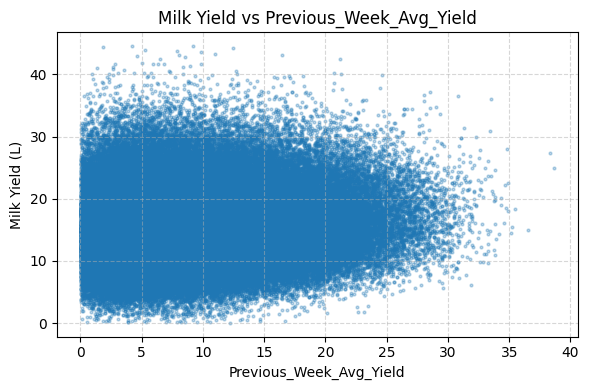

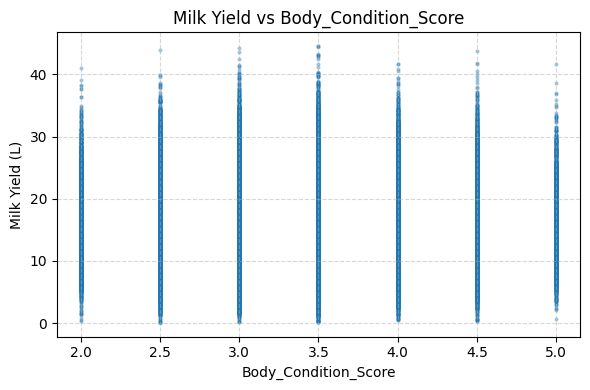

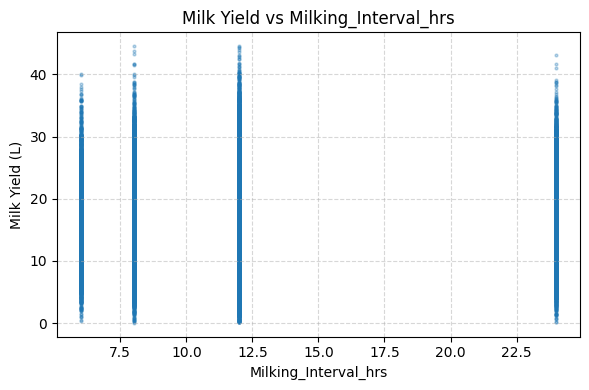

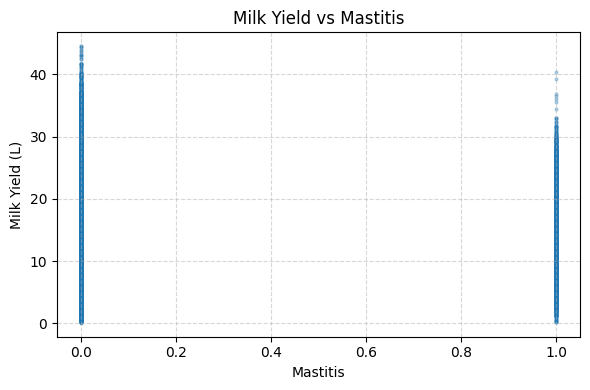

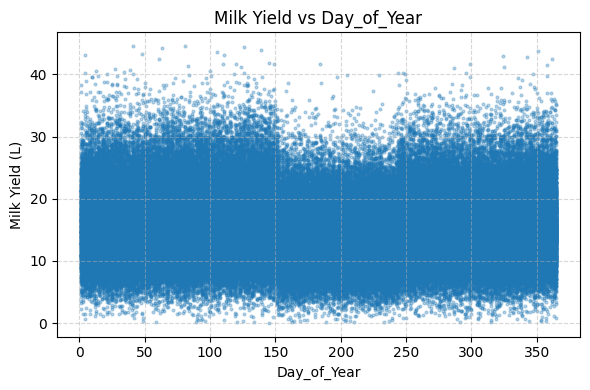

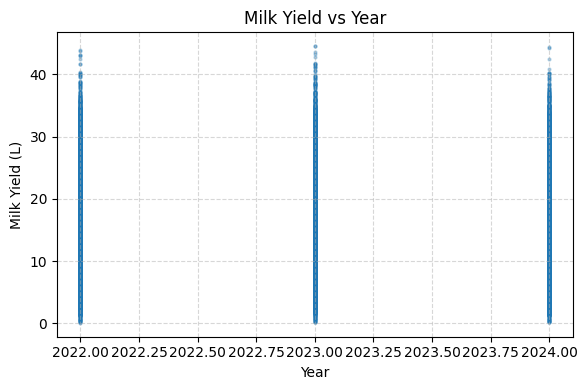

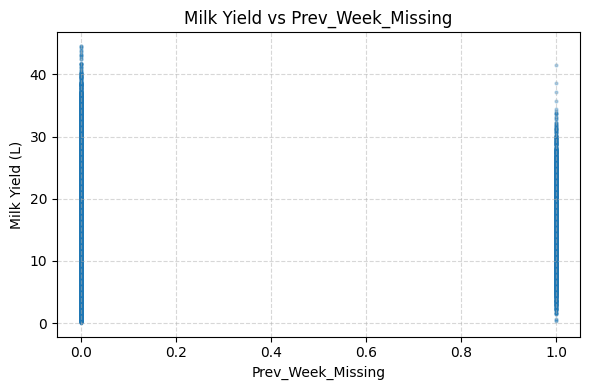

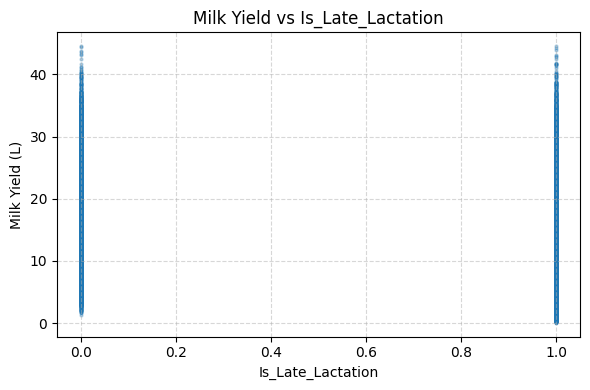

In [17]:
# DATA EXPLORATION: Scatterplots of Numeric Features vs Milk Yield

# Honestly nothing to take away from here which makes sense since we saw very low correlations earlier, at most 0.3
for col in numeric_cols:
    if (col != 'Milk_Yield_L'):
        plt.figure(figsize=(6,4))
        plt.scatter(df[col], df['Milk_Yield_L'], s=4, alpha=0.3)
        plt.title(f"Milk Yield vs {col}")
        plt.xlabel(col)
        plt.ylabel("Milk Yield (L)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

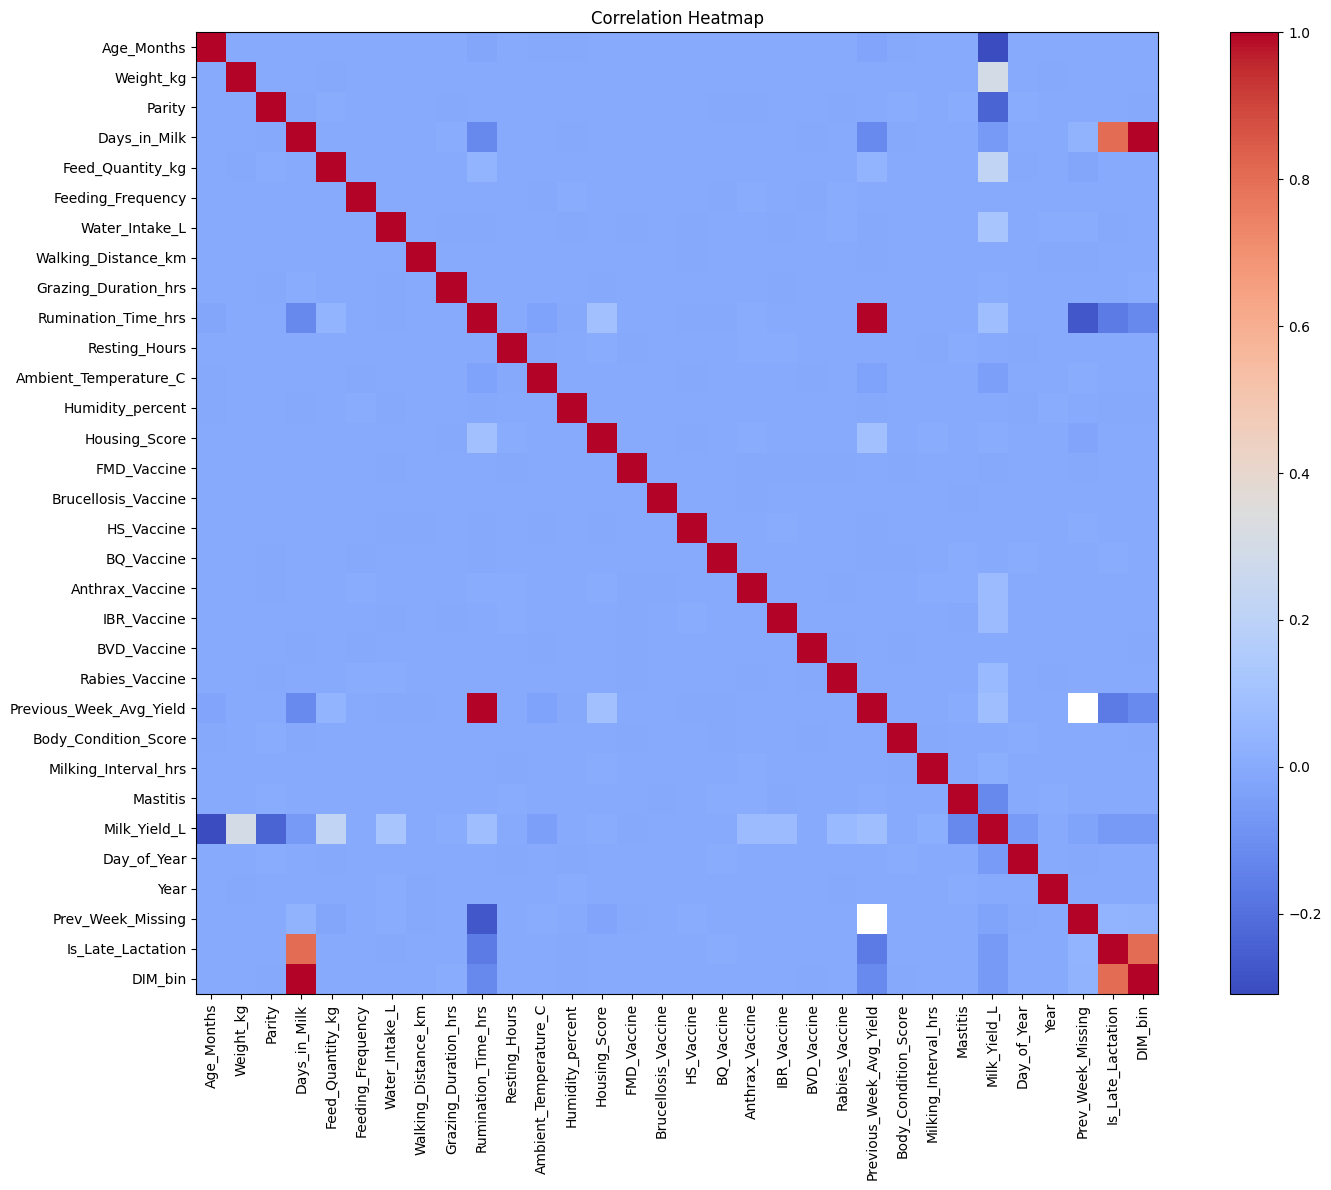

In [18]:
# DATA EXPLORATION: Correlation Heatmap Between Numeric Features
corr = df.corr(numeric_only=True)

plt.figure(figsize=(16,12))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

plt.title("Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.tight_layout()
plt.show()


Categorical columns: ['Breed', 'Climate_Zone', 'Management_System', 'Lactation_Stage', 'Feed_Type', 'Farm_ID']


/var/folders/0t/18dj_kzj47n6hnpp3116st0c0000gn/T/ipykernel_1453/1125134905.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


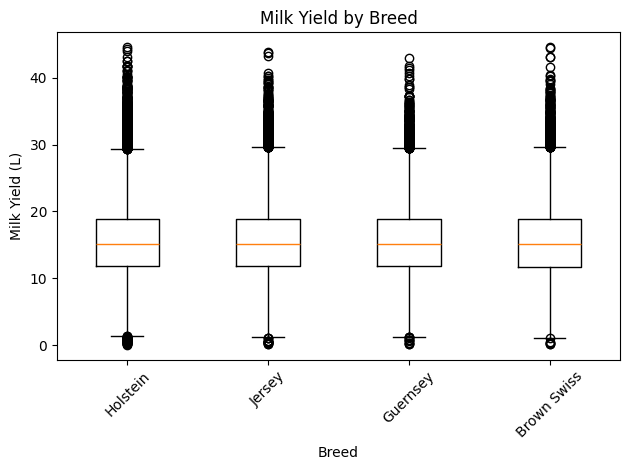

/var/folders/0t/18dj_kzj47n6hnpp3116st0c0000gn/T/ipykernel_1453/1125134905.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


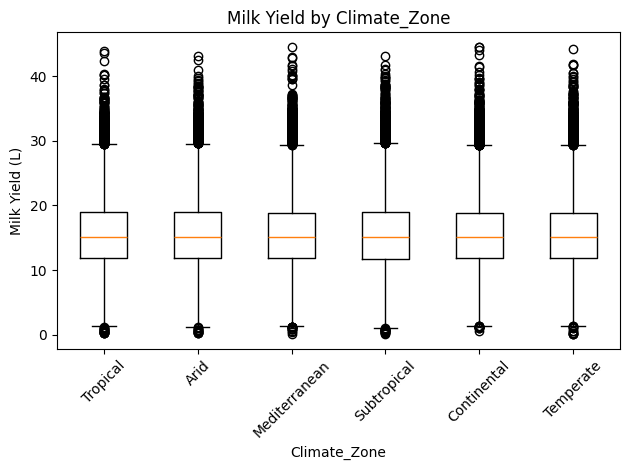

/var/folders/0t/18dj_kzj47n6hnpp3116st0c0000gn/T/ipykernel_1453/1125134905.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


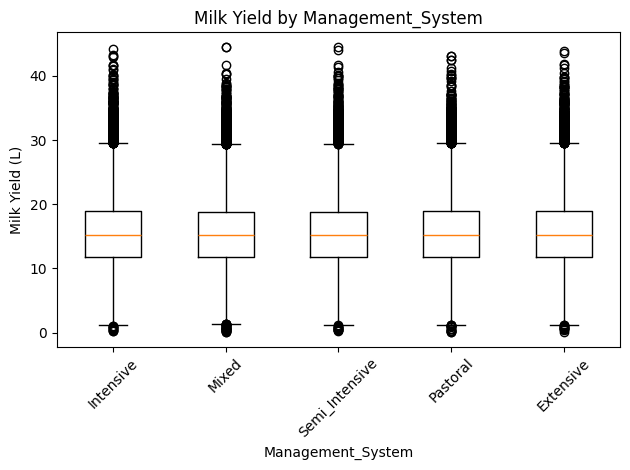

/var/folders/0t/18dj_kzj47n6hnpp3116st0c0000gn/T/ipykernel_1453/1125134905.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


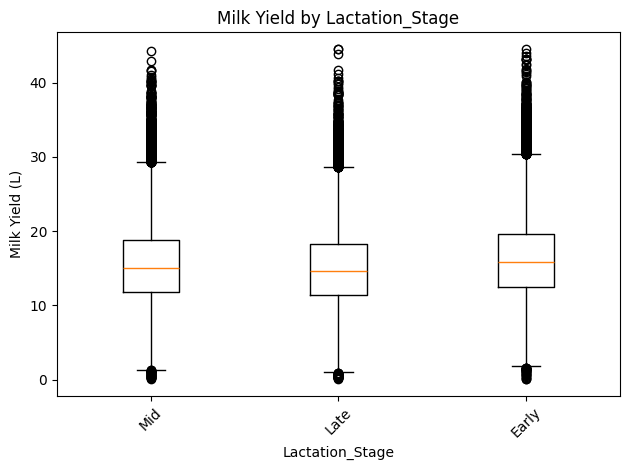

/var/folders/0t/18dj_kzj47n6hnpp3116st0c0000gn/T/ipykernel_1453/1125134905.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=categories)


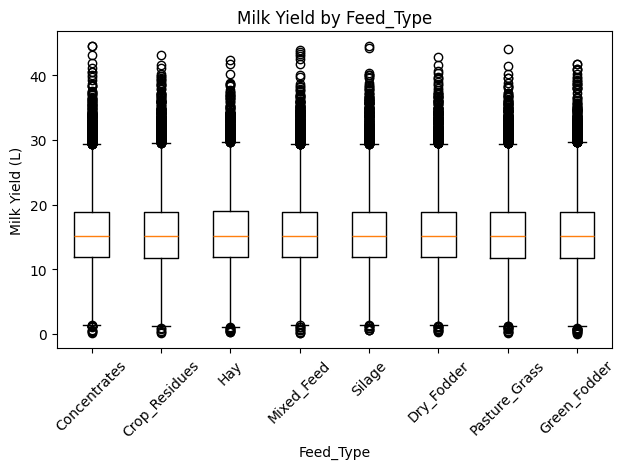

In [19]:
# DATA EXPLORATION: Boxplots of Categorical Features vs Milk Yield

categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols.tolist())

# Lets go ahead and drop Date and Farm_ID for now since they have too many unique categories to visualize effectively
cols_to_drop = [col for col in ['Date', 'Farm_ID'] if col in categorical_cols]
categorical_cols = categorical_cols.drop(cols_to_drop)

for col in categorical_cols:
    categories = df[col].dropna().unique()

    data = [df.loc[df[col] == category, 'Milk_Yield_L'].values for category in categories]

    plt.boxplot(data, labels=categories)
    plt.title(f"Milk Yield by {col}")
    plt.ylabel("Milk Yield (L)")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Visually all of these categorical features look almost identically distibuted for Milk_Yield_L

# Feature Engineering

In [20]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# DATA PREPROCESSING PIPELINE (convert into a pipeline to pass into models differently later)
# We should have different pipelines for NaN imputation, low variance filter, correlation filter, scaling. one hot encoding, ordinal encoding, etc.



# THE PLAN:
# Rumination seems to have some weird values, half of them are negative and they go up to over 24 hours a day? We will leave it as is since so much of the data seems to be like that
# 


# Now we split our data into features and labels
features = df.drop(columns=['Milk_Yield_L'])
labels = df['Milk_Yield_L']


numeric_features = features.select_dtypes(include=[np.number]).columns.tolist()
one_hot_features = ['Breed', 'Climate_Zone', 'Management_System', 'Feed_Type'] # We are using one hot for now, hopefully this isnt too many dimensions, but may use frequency encoding later
ordinal_features = ['Lactation_Stage']
target_features = ["Farm_ID"]
# frequency_encoding_features = ['Farm_ID'] # might use target encoding or some other form later, frequency seems bad
lactation_order = ['Early', 'Mid', 'Late']


# PIPELINES
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])
unscaled_numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
onehot_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[lactation_order]))
])
target_enc_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_enc', TargetEncoder())
])


scaled_preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('onehot', onehot_pipeline, one_hot_features),
    ('ordinal', ordinal_pipeline, ordinal_features),
    ('target', target_enc_pipeline, target_features)
])

# This is the one we will use for models like decision forests that don't need scaling
unscaled_preprocessor = ColumnTransformer(transformers=[
    ('num', unscaled_numeric_pipeline, numeric_features),
    ('onehot', onehot_pipeline, one_hot_features),
    ('ordinal', ordinal_pipeline, ordinal_features),
    ('target', target_enc_pipeline, target_features)
])






# DATA EXPLORATION NOTES
# Data may need to be scaled in our CV-loop later based on the model we choose to use
# Feed_Quantity_kg has some NaN entries that need to be replaced
# more relevant features: breed, age, weight, lactation stage, Previous_Week_Avg_Yield,Body_Condition_Score, Mastitis


# TODO:
# imputation using mean/median (or ffill if we're lazy) for food quantity NaNs (about 16k of them)
# We have a LOT of low variance features, maybe filter them out if they seem irrelevant

In [21]:
# Model comparison with 5-fold CV and prediction export
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import clone

# Split data into train/validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Helper to compute accuracy-style metrics for regression
EPS = 1e-8

def regression_accuracy_metrics(y_true, y_pred):
    rel_error = np.abs(y_pred - y_true) / (np.abs(y_true) + EPS)
    return {
        'Accuracy_10pct': np.mean(rel_error <= 0.10) * 100,
        'Accuracy_20pct': np.mean(rel_error <= 0.20) * 100,
        'Accuracy_1L': np.mean(np.abs(y_pred - y_true) <= 1.0) * 100,
        'Accuracy_2L': np.mean(np.abs(y_pred - y_true) <= 2.0) * 100,
    }

# Configure models and hyperparameter grids
model_configs = {
    'LinearRegression': {
        'pipeline': Pipeline([
            ('preprocessor', scaled_preprocessor),
            ('model', LinearRegression())
        ]),
        'param_grid': {}
    },
    'RidgeRegression': {
        'pipeline': Pipeline([
            ('preprocessor', scaled_preprocessor),
            ('model', Ridge())
        ]),
        'param_grid': {
            'model__alpha': [0.1, 1.0, 10.0]
        }
    },
    'RandomForest': {
        'pipeline': Pipeline([
            ('preprocessor', unscaled_preprocessor),
            ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
        ]),
        'param_grid': {
            'model__n_estimators': [200],
            'model__max_depth': [None, 20],
            'model__max_features': ['sqrt']
        }
    },
    'GradientBoosting': {
        'pipeline': Pipeline([
            ('preprocessor', scaled_preprocessor),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        'param_grid': {
            'model__n_estimators': [200, 400],
            'model__learning_rate': [0.05],
            'model__max_depth': [3, 5]
        }
    }
}

results = []
trained_grids = {}

for model_name, config in model_configs.items():
    print(f"Training {model_name} with 5-fold CV...")
    grid = GridSearchCV(
        config['pipeline'],
        config['param_grid'],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_valid)

    r2 = r2_score(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    acc_metrics = regression_accuracy_metrics(y_valid, y_pred)

    result_row = {
        'Model': model_name,
        'BestParams': grid.best_params_,
        'CV_R2': grid.best_score_,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        **acc_metrics
    }
    results.append(result_row)
    trained_grids[model_name] = grid

results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print("\nModel comparison (sorted by validation R²):")
results_df

best_model_name = results_df.iloc[0]['Model']
best_grid = trained_grids[best_model_name]
print(f"\nBest model selected: {best_model_name}")
print(f"Best hyperparameters: {best_grid.best_params_}")



# Training LinearRegression with 5-fold CV...
# Fitting 5 folds for each of 1 candidates, totalling 5 fits
# Training RidgeRegression with 5-fold CV...
# Fitting 5 folds for each of 3 candidates, totalling 15 fits
# Training RandomForest with 5-fold CV...
# Fitting 5 folds for each of 2 candidates, totalling 10 fits
# Training GradientBoosting with 5-fold CV...
# Fitting 5 folds for each of 4 candidates, totalling 20 fits

# Model comparison (sorted by validation R²):

# Best model selected: GradientBoosting
# Best hyperparameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 400}

Training LinearRegression with 5-fold CV...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training RidgeRegression with 5-fold CV...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training RandomForest with 5-fold CV...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Training GradientBoosting with 5-fold CV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Model comparison (sorted by validation R²):

Best model selected: GradientBoosting
Best hyperparameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 400}


# Neural Network with PCA

In [24]:
# Neural Network with PCA - Testing various architectures and activation functions
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a preprocessor with PCA for neural networks
# StandardScaler acts similar to batch normalization
pca_nn_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  # Similar effect to batch normalization
    ('pca', PCA(n_components=0.95))  # Keep 95% of variance
])

# Preprocessor for categorical features
pca_nn_preprocessor = ColumnTransformer(transformers=[
    ('num', pca_nn_pipeline, numeric_features),
    ('onehot', onehot_pipeline, one_hot_features),
    ('ordinal', ordinal_pipeline, ordinal_features),
    ('target', target_enc_pipeline, target_features)
])

# Configure different neural network architectures
nn_configs = {
    'NN_Small_ReLU': {
        'pipeline': Pipeline([
            ('preprocessor', pca_nn_preprocessor),
            ('model', MLPRegressor(random_state=42, max_iter=500, early_stopping=True))
        ]),
        'param_grid': {
            'model__hidden_layer_sizes': [(50,), (100,)],
            'model__activation': ['relu'],
            'model__solver': ['adam'],
            'model__alpha': [0.0001, 0.001],  # L2 regularization
            'model__learning_rate': ['adaptive']
        }
    },
    'NN_Deep_ReLU': {
        'pipeline': Pipeline([
            ('preprocessor', pca_nn_preprocessor),
            ('model', MLPRegressor(random_state=42, max_iter=500, early_stopping=True))
        ]),
        'param_grid': {
            'model__hidden_layer_sizes': [(100, 50), (100, 100, 50)],
            'model__activation': ['relu'],
            'model__solver': ['adam'],
            'model__alpha': [0.0001, 0.001],
            'model__learning_rate': ['adaptive']
        }
    },
    'NN_Tanh': {
        'pipeline': Pipeline([
            ('preprocessor', pca_nn_preprocessor),
            ('model', MLPRegressor(random_state=42, max_iter=500, early_stopping=True))
        ]),
        'param_grid': {
            'model__hidden_layer_sizes': [(100,), (100, 50)],
            'model__activation': ['tanh'],
            'model__solver': ['adam'],
            'model__alpha': [0.0001, 0.001],
            'model__learning_rate': ['adaptive']
        }
    },
    'NN_Sigmoid_SGD': {
        'pipeline': Pipeline([
            ('preprocessor', pca_nn_preprocessor),
            ('model', MLPRegressor(random_state=42, max_iter=500, early_stopping=True))
        ]),
        'param_grid': {
            'model__hidden_layer_sizes': [(50,), (100, 50)],
            'model__activation': ['logistic'],  # sigmoid in sklearn
            'model__solver': ['sgd'],
            'model__momentum': [0.9],
            'model__alpha': [0.0001, 0.001],
            'model__learning_rate': ['constant', 'adaptive']
        }
    }
}

nn_results = []
nn_trained_grids = {}

print("Training Neural Networks with PCA...\n")
for model_name, config in nn_configs.items():
    print(f"Training {model_name} with 5-fold CV...")
    grid = GridSearchCV(
        config['pipeline'],
        config['param_grid'],
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    start_time = time.time()
    grid.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    y_pred = grid.predict(X_valid)
    
    r2 = r2_score(y_valid, y_pred)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    acc_metrics = regression_accuracy_metrics(y_valid, y_pred)
    
    result_row = {
        'Model': model_name,
        'BestParams': grid.best_params_,
        'CV_R2': grid.best_score_,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'TrainTime_sec': train_time,
        **acc_metrics
    }
    nn_results.append(result_row)
    nn_trained_grids[model_name] = grid
    
    print(f"  -> RMSE: {rmse:.4f}, R²: {r2:.4f}, Time: {train_time:.1f}s\n")

nn_results_df = pd.DataFrame(nn_results).sort_values(by='RMSE', ascending=True)
print("\n" + "="*80)
print("Neural Network Results (sorted by RMSE):")
print("="*80)
print(nn_results_df[['Model', 'RMSE', 'R2', 'MAE', 'TrainTime_sec']].to_string(index=False))
print("\nBest Neural Network Configuration:")
print(f"Model: {nn_results_df.iloc[0]['Model']}")
print(f"RMSE: {nn_results_df.iloc[0]['RMSE']:.4f}")
print(f"R²: {nn_results_df.iloc[0]['R2']:.4f}")
print(f"Best Params: {nn_results_df.iloc[0]['BestParams']}")

Training Neural Networks with PCA...

Training NN_Small_ReLU with 5-fold CV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  -> RMSE: 4.2109, R²: 0.3824, Time: 40.5s

Training NN_Deep_ReLU with 5-fold CV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  -> RMSE: 4.2109, R²: 0.3824, Time: 40.5s

Training NN_Deep_ReLU with 5-fold CV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  -> RMSE: 4.1983, R²: 0.3861, Time: 49.4s

Training NN_Tanh with 5-fold CV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  -> RMSE: 4.1983, R²: 0.3861, Time: 49.4s

Training NN_Tanh with 5-fold CV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
  -> RMSE: 4.1790, R²: 0.3917, Time: 34.3s

Training NN_Sigmoid_SGD with 5-fold CV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
  -> RMSE: 4.1790, R²: 0.3917, Time: 34.3s

Training NN_Sigmoid_SGD with 5-fold CV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
  -

In [22]:
# Prepare the competition test set using the same feature engineering steps
raw_test_df = pd.read_csv("cattle_data_test.csv")
submission_ids = raw_test_df['Cattle_ID'].copy()

def apply_training_transforms(df_input):
    df_temp = df_input.copy()
    df_temp['Breed'] = df_temp['Breed'].str.strip()
    df_temp['Breed'] = df_temp['Breed'].replace('Holstien', 'Holstein')

    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    df_temp['Day_of_Year'] = df_temp['Date'].dt.dayofyear
    df_temp['Year'] = df_temp['Date'].dt.year
    df_temp = df_temp.drop(columns=['Date'])

    if 'Feed_Quantity_lb' in df_temp.columns:
        df_temp['Feed_Quantity_kg'] = df_temp['Feed_Quantity_kg'].fillna(
            df_temp['Feed_Quantity_lb'] * FEED_QTY_LBS_TO_KG
        )
        df_temp = df_temp.drop(columns=['Feed_Quantity_lb'])

    df_temp['Previous_Week_Avg_Yield'] = df_temp['Previous_Week_Avg_Yield'].replace(0, np.nan)
    df_temp['Prev_Week_Missing'] = df_temp['Previous_Week_Avg_Yield'].isna().astype(int)
    df_temp['Is_Late_Lactation'] = (df_temp['Days_in_Milk'] > 250).astype(int)
    return df_temp

processed_test_df = apply_training_transforms(raw_test_df)
processed_test_features = processed_test_df.drop(columns=['Cattle_ID'])
processed_test_features = processed_test_features.reindex(columns=features.columns, fill_value=0)

# Fit the best model on the entire training dataset
final_model = clone(model_configs[best_model_name]['pipeline'])
final_model.set_params(**best_grid.best_params_)
final_model.fit(features, labels)

test_predictions = final_model.predict(processed_test_features)
submission = pd.DataFrame({
    'Cattle_ID': submission_ids,
    'Predicted_Milk_Yield_L': test_predictions
})

submission_path = "predicted_milk_yield.csv"
submission.to_csv(submission_path, index=False)
print(f"Predictions saved to {submission_path}")

Predictions saved to predicted_milk_yield.csv


In [23]:
print(results_df[['Model', 'R2', 'RMSE']])


              Model        R2      RMSE
3  GradientBoosting  0.409283  4.118334
2      RandomForest  0.366559  4.264668
0  LinearRegression  0.357846  4.293898
1   RidgeRegression  0.357843  4.293905
